In [1]:
import numpy as np
from gwbench import network

/home/sreelakshmi/anaconda3/envs/igwn-py310/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## User Choices

#### choose the desired detectors

In [2]:
network_spec = ['aLIGO_H','aLIGO_L','aLIGO_V']

#### initialize the network with the desired detectors

In [3]:
net = network.Network(network_spec)

#### choose the desired waveform 

In [4]:
wf_model_name = 'lal_bbh_jframe'

#### pass the chosen waveform to the network for initialization

In [5]:
net.set_wf_vars(wf_model_name=wf_model_name)

#### pick the desired frequency range

In [6]:
f = np.arange(5.,1024,2**-4)
print(len(f))

16304


#### set the injection parameters

In [7]:
inj_params = {
    'Mc':          27.9,
    'eta':         0.249,
    'a_1':         0.34,
    'a_2':         0.34,
    'tilt_1':      0,
    'tilt_2':      0,
    'phi_12':      0,
    'phi_jl':      0,
    'theta_jn':    0,
    'DL':          470,
    'tc':          0,
    'phic':        0,
    'approximant': 'IMRPhenomXP',
    'ra':          np.pi/4,
    'dec':         np.pi/4,
    'psi':         np.pi/4,
    'gmst0':       0
    }

In [8]:

from gwbench import basic_relations
tot_mass = basic_relations.M_of_Mc_eta(27.9, 0.249)
print(tot_mass)
m1,m2 = basic_relations.m1_m2_of_M_eta(tot_mass,0.249)
print(m1,m2)
k= m1/(m1+m2)
print(k)

64.25169587301812
34.15766496138084 30.09403091163728
0.5316227766016838


In [9]:
deriv_symbs_string = 'Mc eta a_1 DL tc phic'

#### assign which parameters to convert to cos or log versions

In [10]:
#conv_cos = ('dec')
#conv_log = ('Mc','DL')

#### choose whether to take Earth's rotation into account

In [11]:
use_rot = 0

#### pass all these variables to the network

In [12]:
net.set_net_vars(
    f=f, inj_params=inj_params,
    deriv_symbs_string=deriv_symbs_string,
    use_rot=use_rot
    )

## GW benchmarking

#### compute the WF polarizations

In [13]:
net.calc_wf_polarizations()
f0=net.hfc
print(len(f0))
#print(f0)

2023-10-11 10:54:23,701 - Network - INFO : Polarizations calculated.


16304


#### compute the WF polarizations and their derivatives

In [14]:
net.calc_wf_polarizations_derivs_num()
f1=net.del_hfpc
print(len(f1))
#print(f1)

for key in f1.keys():
   print(key)


2023-10-11 10:54:23,762 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-10-11 10:54:23,820 - Network - INFO : Polarizations calculated.
2023-10-11 10:54:28,332 - Network - INFO : Numeric derivatives of polarizations calculated.


12
del_Mc_hfp
del_Mc_hfc
del_eta_hfp
del_eta_hfc
del_a_1_hfp
del_a_1_hfc
del_DL_hfp
del_DL_hfc
del_tc_hfp
del_tc_hfc
del_phic_hfp
del_phic_hfc


In [15]:
### edited in gwbench for generating waveform using j-frame parameters. 

import lal
import lalsimulation as lalsim
from numpy import exp, pi

from gwbench.basic_relations import m1_m2_of_M_eta, M_of_Mc_eta
from gwbench.utils import Mpc, Msun

wf_symbs_string = 'f Mc eta a_1 a_2 tilt_1 tilt_2 phi_12 phi_jl theta_jn DL tc phic approximant'

def hfpc(f, Mc, eta, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl, theta_jn, DL, tc, phic,  approximant, fRef=0., phiRef=0.):
    f_min   = f[0]
    delta_f = f[1] - f[0]
    f_max   = f[-1] + delta_f

    if not fRef: fRef = f_min

    _m1, _m2 = m1_m2_of_M_eta(M_of_Mc_eta(Mc,eta),eta)
    _m1 *= Msun
    _m2 *= Msun
    _DL = DL * Mpc

    approx = lalsim.GetApproximantFromString(approximant)

    if 'IMRPhenomX' in approximant:
        lal_dict = lal.CreateDict()
        lalsim.SimInspiralWaveformParamsInsertPhenomXHMThresholdMband(lal_dict, 0)
    else:
        lal_dict = None
        
    
    iota, spin1x, spin1y, spin1z, spin2x, spin2y, spin2z = lalsim.SimInspiralTransformPrecessingNewInitialConditions(theta_jn, phi_jl, tilt_1, tilt_2, phi_12,a_1, a_2, _m1, _m2, fRef, phiRef)     

    hPlus, hCross = lalsim.SimInspiralChooseFDWaveform(m1=_m1, m2=_m2,
                                   S1x = spin1x, S1y = spin1y, S1z = spin1z,
                                   S2x = spin2x, S2y = spin2y, S2z = spin2z,
                                   distance = _DL, inclination = iota, phiRef = phiRef,
                                   longAscNodes=0., eccentricity=0., meanPerAno = 0.,
                                   deltaF=delta_f, f_min=f_min, f_max=f_max, f_ref=fRef,
                                   LALpars=lal_dict, approximant=approx)

    pf = exp(1j*(2*f*pi*tc - phic))
    i0 = int(round((f_min-hPlus.f0) / delta_f))

    hfp = pf *  hPlus.data.data[i0:i0+len(f)]
    hfc = pf * hCross.data.data[i0:i0+len(f)]
    #params = [iota, spin1x, spin1y, spin1z, spin2x, spin2y, spin2z]
    return hfp

a = hfpc(f, 27.9, 0.249, 0.34, 0.34, np.pi/4, np.pi/4, 0, 0, 0, 470, 0, 0, 'IMRPhenomXP', fRef=0., phiRef=0.)
print(a)

[-2.80408546e-22-2.80408546e-22j  1.32582370e-22-3.67579710e-22j
  3.30645882e-22-1.97756077e-22j ...  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]


In [16]:
# gwbench code for generating the waveform using l-frame parameters
import lal
import lalsimulation as lalsim
from numpy import exp, pi

from gwbench.basic_relations import m1_m2_of_M_eta, M_of_Mc_eta
from gwbench.utils import Mpc, Msun

wf_symbs_string = 'f Mc eta chi1x chi1y chi1z chi2x chi2y chi2z DL tc phic iota approximant'

def hfpc(f, Mc, eta, chi1x, chi1y, chi1z, chi2x, chi2y, chi2z, DL, tc, phic, iota, approximant, fRef=0., phiRef=0.):
    f_min   = f[0]
    delta_f = f[1] - f[0]
    f_max   = f[-1] + delta_f

    if not fRef: fRef = f_min

    _m1, _m2 = m1_m2_of_M_eta(M_of_Mc_eta(Mc,eta),eta)
    _m1 *= Msun
    _m2 *= Msun
    _DL = DL * Mpc

    approx = lalsim.GetApproximantFromString(approximant)

    if 'IMRPhenomX' in approximant:
        lal_dict = lal.CreateDict()
        lalsim.SimInspiralWaveformParamsInsertPhenomXHMThresholdMband(lal_dict, 0)
    else:
        lal_dict = None

    hPlus, hCross = lalsim.SimInspiralChooseFDWaveform(m1=_m1, m2=_m2,
                                   S1x = chi1x, S1y = chi1y, S1z = chi1z,
                                   S2x = chi2x, S2y = chi2y, S2z = chi2z,
                                   distance = _DL, inclination = iota, phiRef = phiRef,
                                   longAscNodes=0., eccentricity=0., meanPerAno = 0.,
                                   deltaF=delta_f, f_min=f_min, f_max=f_max, f_ref=fRef,
                                   LALpars=lal_dict, approximant=approx)

    pf = exp(1j*(2*f*pi*tc - phic))
    i0 = int(round((f_min-hPlus.f0) / delta_f))

    hfp = pf *  hPlus.data.data[i0:i0+len(f)]
    hfc = pf * hCross.data.data[i0:i0+len(f)]

    return hfp

b= hfpc(f, 27.9, 0.249, -1.4721252956003386e-17, 0.24041630560342617, 0.2404163056034262, -1.4721252956003386e-17, 0.24041630560342617, 0.2404163056034262, 470, 0, 0, 0, 'IMRPhenomXP', fRef=0., phiRef=0.) 
print(b)
print(len(b))

[-2.81160092e-22-2.81160092e-22j  1.31885756e-22-3.68668229e-22j
  3.29837131e-22-1.99181652e-22j ...  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
16304


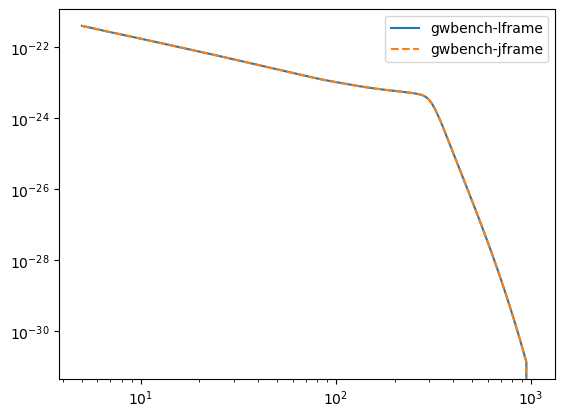

In [17]:
import matplotlib.pyplot as plt
plt.loglog(f,np.abs(b),label= 'gwbench-lframe')
plt.loglog(f,np.abs(a),label= 'gwbench-jframe', linestyle='dashed')
plt.legend()
plt.show()

#### setup antenna patterns, location phase factors, and PSDs

In [18]:
net.setup_ant_pat_lpf_psds()

2023-10-11 10:54:32,614 - Network - INFO : PSDs loaded.
2023-10-11 10:54:32,621 - Network - INFO : Antenna patterns and LPFs loaded.


#### compute the detector responses

In [19]:
net.calc_det_responses()

2023-10-11 10:54:33,259 - Network - INFO : Detector responses calculated.


#### compute the detector responses and their derivatives

In [20]:
net.calc_det_responses_derivs_num()

2023-10-11 10:54:33,299 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-11 10:54:33,309 - Network - INFO :    aLIGO_H
2023-10-11 10:54:35,559 - Network - INFO :    aLIGO_L
2023-10-11 10:54:37,890 - Network - INFO :    aLIGO_V
2023-10-11 10:54:40,159 - Network - INFO : Numeric derivatives of detector responses calculated.


#### calculate the network and detector SNRs

In [21]:
net.calc_snrs()

2023-10-11 10:54:40,174 - Network - INFO : SNRs calculated.


#### calculate the network and detector Fisher matrices, condition numbers, covariance matrices, error estimates, and inversion errors

In [22]:
net.calc_errors()

2023-10-11 10:54:40,217 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-11 10:54:40,218 - Network - INFO :    aLIGO_H
2023-10-11 10:54:40,327 - Network - INFO :    aLIGO_L
2023-10-11 10:54:40,374 - Network - INFO :    aLIGO_V
2023-10-11 10:54:40,426 - Network - INFO : Errors calculated.


#### calculate the 90%-credible sky area (in deg)

In [23]:
net.calc_sky_area_90()

2023-10-11 10:54:40,434 - Network - WARNING : calc_sky_area_90: tag = network - Nothing done due to missing of either RA or COS_DEC (DEC) errors.


In [24]:
h_ul=net.detectors[2].hf
print(len(h_ul))
A_ul=np.abs(h_ul)
phi_ul= np.angle(h_ul)

16224


In [25]:
f2=net.detectors[2].del_hf
print(len(f2))
#print(f2)
key_list = list(f2.keys()) # returns a list containing the derivatives for each parameter.
print(key_list)
#for i in range(len(key_list)):
#print(f2[key_list[0]])
print(len(f2[key_list[4]]))
a=f2[key_list[2]]
print(a[:10])

6
['del_Mc_hf', 'del_eta_hf', 'del_a_1_hf', 'del_DL_hf', 'del_tc_hf', 'del_phic_hf']
16224
[-8.15569400e-25+2.69528904e-24j  1.96751378e-23-1.93163034e-23j
  8.58019608e-24+5.35817120e-23j -7.43133422e-23-3.05360043e-23j
  8.25979323e-23-6.61281033e-23j  2.67681026e-23+1.27885437e-22j
 -1.50899540e-22-3.49873959e-23j  1.05038040e-22-1.44413661e-22j
  1.09342087e-22+1.69451735e-22j -2.18030508e-22+5.22800812e-23j]


In [26]:
f3=net.detectors[2].fisher
print(f3)

[[ 3.08063366e+05 -3.96525550e+06 -1.06199473e+06 -4.29074743e-01
  -1.19804170e+07  4.01339444e+04]
 [-3.96525550e+06  8.28041442e+07  2.24133094e+07 -1.84725300e+01
   4.54363320e+08 -7.44590517e+05]
 [-1.06199473e+06  2.24133094e+07  6.07575588e+06 -1.92271131e+00
   1.24130633e+08 -2.01447421e+05]
 [-4.29074743e-01 -1.84725300e+01 -1.92271131e+00  3.17857560e-02
   2.91239913e-02 -5.63109743e-05]
 [-1.19804170e+07  4.54363320e+08  1.24130633e+08  2.91239913e-02
   3.37291291e+09 -3.80119423e+06]
 [ 4.01339444e+04 -7.44590517e+05 -2.01447421e+05 -5.63109743e-05
  -3.80119423e+06  7.02175085e+03]]


In [27]:
cov_matrix =net.detectors[2].cov
print(cov_matrix)

[[ 4.8680016e-04  2.8083352e-05 -1.7113607e-05  2.1856233e-02
  -4.5062902e-06 -2.7348432e-03]
 [ 2.8083352e-05  1.1339472e-05 -3.7415797e-05  4.7057788e-03
  -2.2131334e-07 -1.5130168e-04]
 [-1.7113607e-05 -3.7415797e-05  1.4523846e-04 -1.3189530e-02
  -7.9333162e-08  2.5403075e-04]
 [ 2.1856233e-02  4.7057788e-03 -1.3189530e-02  3.3692619e+01
  -1.9424509e-04 -1.0946795e-01]
 [-4.5062902e-06 -2.2131334e-07 -7.9333162e-08 -1.9424509e-04
   4.3693486e-08  2.3665512e-05]
 [-2.7348432e-03 -1.5130168e-04  2.5403075e-04 -1.0946795e-01
   2.3665512e-05  1.9828858e-02]]


In [28]:
for i in np.arange(0,6):
   err= np.sqrt(cov_matrix[i,i])
   print(err)
                


0.022063548
0.0033674133
0.012051492
5.8045344
0.00020902987
0.14081497


In [29]:
from gwbench import fisher_analysis_tools
n=fisher_analysis_tools.calc_cond_number(f3)
print(n)

115876357657.37675


In [30]:
n = 6
prior_matrix = np.zeros((n, n), dtype=float)
prior_matrix[2,2] = 2.77
#prior_matrix[3,3] = 1/(np.pi/4)**2
prior_matrix[5,5] = 1/(np.pi**2)
#print(prior_matrix)
prior_fisher = f3 + prior_matrix
print(prior_fisher)

[[ 3.08063366e+05 -3.96525550e+06 -1.06199473e+06 -4.29074743e-01
  -1.19804170e+07  4.01339444e+04]
 [-3.96525550e+06  8.28041442e+07  2.24133094e+07 -1.84725300e+01
   4.54363320e+08 -7.44590517e+05]
 [-1.06199473e+06  2.24133094e+07  6.07575865e+06 -1.92271131e+00
   1.24130633e+08 -2.01447421e+05]
 [-4.29074743e-01 -1.84725300e+01 -1.92271131e+00  3.17857560e-02
   2.91239913e-02 -5.63109743e-05]
 [-1.19804170e+07  4.54363320e+08  1.24130633e+08  2.91239913e-02
   3.37291291e+09 -3.80119423e+06]
 [ 4.01339444e+04 -7.44590517e+05 -2.01447421e+05 -5.63109743e-05
  -3.80119423e+06  7.02185218e+03]]


In [31]:
def invertSVD(matrix):
    '''
    Adapted from GWFish
    '''
    thresh = 1e-10

    dm = np.sqrt(np.diag(matrix))
    normalizer = np.outer(dm, dm)
    matrix_norm = matrix / normalizer

    [U, S, Vh] = np.linalg.svd(matrix_norm)

    kVal = sum(S > thresh)
    matrix_inverse_norm = U[:, 0:kVal] @ np.diag(1. / S[0:kVal]) @ Vh[0:kVal, :]

    # print(matrix @ (matrix_inverse_norm / normalizer))

    return matrix_inverse_norm / normalizer, S

In [32]:
new_cov = invertSVD(prior_fisher)

In [33]:
print(new_cov[0])

[[ 4.86043040e-04  2.80397444e-05 -1.70365027e-05  2.18253388e-02
  -4.49974932e-06 -2.72934770e-03]
 [ 2.80397444e-05  1.13332816e-05 -3.73968646e-05  4.70273821e-03
  -2.20959558e-07 -1.50972048e-04]
 [-1.70365027e-05 -3.73968646e-05  1.45173528e-04 -1.31814154e-02
  -7.99089128e-08  2.53419461e-04]
 [ 2.18253388e-02  4.70273821e-03 -1.31814154e-02  3.36909279e+01
  -1.93986059e-04 -1.09239211e-01]
 [-4.49974932e-06 -2.20959558e-07 -7.99089128e-08 -1.93986059e-04
   4.36368364e-08  2.36181180e-05]
 [-2.72934770e-03 -1.50972048e-04  2.53419461e-04 -1.09239211e-01
   2.36181180e-05  1.97889210e-02]]


In [34]:
from gwbench import fisher_analysis_tools
n=fisher_analysis_tools.calc_cond_number(f3)
print(n)

115876357657.37675


In [35]:
for i in np.arange(0,6):
   err= np.sqrt(new_cov[0][i,i])
   print(err)


0.022046383835090076
0.003366493959332803
0.012048797773381225
5.804388678705879
0.00020889431876680784
0.1406730998539703


#### calculation of systematic errors

In [36]:
from gwbench.wf_models import py_lgw
lgw = py_lgw.lensed_wf_gen()
x = (1e1, 5e1, 1e2, 5e2, 1e3, 5e3, 1e4, 5e4, 1e5)
y = (0.01, 0.05, 0.1, 0.5, 1.0, 3.0, 5.0)
chirp_time = lgw.tchirp_2PN(64.25, 0.249, f_low=10) # returns the chirptime given the total mass,eta and low frequency cut off.
#print(chirp_time)
ml_y_pairs = []
for i in x:
    for j in y:
        time_delay= lgw.td_point_sec(i, j, zl=0)
        if time_delay < chirp_time:
            pairs = (i,j)
            ml_y_pairs.append(pairs)

print(len(ml_y_pairs))  

59


In [37]:
delta_h_list=[]
for i,j in  ml_y_pairs:
        fs = net.detectors[2].f # returns the truncated frequency array tto the range dictated by the given detector’s PSD
        ws = lgw.w_of_f(fs, ml=i) #Converts a dimensionful frequency (f) to the dimensionless frequency (w)
        Fws = lgw.point_Fw_eff_map(ws,j) # returns an array containing amplification factors
    
        #calculation of  amplitude differences and (A_l-A_ul) and Phase differences using the analytical formula.
        R = np.abs(Fws)
        phi = np.angle(Fws)
        delta_A = A_ul*(R-1)
        delta_phi = phi

        # calculation of deta_h (h_l-h_ul) (reference - Eq.30 arXiv:0707.2982)
        delta_h = (delta_A + 1j*A_ul*delta_phi)*np.exp(1j*phi_ul)
        delta_h_list.append(delta_h)

print(len(delta_h_list))

59


In [38]:
import gwbench.snr as snr_mod
inner_product_list=[]
for j in range(len(delta_h_list)):
    for i in range(len(key_list)):
         inner_product = snr_mod.scalar_product_freq_array(delta_h_list[j], f2[key_list[i]], net.detectors[2].psd, fs)
         inner_product_list.append(inner_product)
print(len(inner_product_list))

354


In [39]:
inner_list_length = 6
sep_inner_product = [inner_product_list[i:i + inner_list_length] for i in range(0, len(inner_product_list), inner_list_length)]
print(len(sep_inner_product))
print(sep_inner_product[0])

59
[4667.153644425226, -131717.18811421996, -36185.267082050865, -1.2746357215151678, -883778.3353380036, 1147.833144491066]


In [40]:
delta_p_list=[]

for i in range (len(sep_inner_product)):
    error =0
    for j in range (0,6):
      
           error += new_cov[0][2,j]* sep_inner_product[i][j]
    delta_p_list.append(error)

print(len(delta_p_list))
abs_err=np.abs(delta_p_list)
print(abs_err)

59
[2.85384773e-02 2.85288377e-02 2.84987102e-02 2.75316694e-02
 2.44772194e-02 6.16839584e-03 5.17875638e-03 1.22212943e-01
 1.21754249e-01 1.20323487e-01 7.66029009e-02 3.79207275e-02
 9.77702306e-03 9.57369991e-05 1.84577704e-01 1.81985221e-01
 1.73955754e-01 3.55662595e-02 2.78511396e-02 8.60462165e-04
 7.32865753e-04 3.84791862e-01 2.48423018e-01 8.32499838e-02
 2.47350586e-02 1.77165914e-04 9.24469694e-04 1.64603381e-04
 5.11650812e-01 1.22473704e-01 6.55270350e-02 2.28693620e-03
 8.02378882e-03 6.31089137e-05 8.07508460e-05 2.79398153e-01
 2.44473149e-02 3.25767237e-04 3.75222115e-04 4.96371101e-04
 7.73123055e-05 1.07207682e-07 1.14315869e-01 5.06964151e-03
 2.24658122e-02 3.03219192e-05 4.60523941e-04 3.71372241e-05
 7.42975699e-07 2.75572754e-02 1.57902866e-03 4.00599490e-04
 2.38354379e-05 3.18761883e-05 3.23193087e-02 6.33861955e-04
 3.89699482e-04 9.86625549e-05 1.18865913e-05]


In [41]:
samples= np.column_stack(ml_y_pairs).T
masses =np.array(samples[:,0])
y= np.array(samples[:, 1])
err=np.array(abs_err)
indices = np.where(abs_err>0.6)
ml_check = masses[indices]
y_check = y[indices]
err_check = err[indices]
print(len(ml_check))
print(ml_check)
print(y_check)
print(err_check)

0
[]
[]
[]


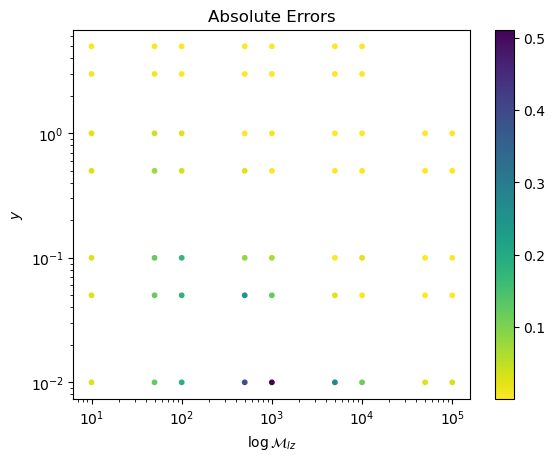

In [42]:
import matplotlib.pyplot as plt

map = plt.cm.get_cmap('viridis')
reversed_map= map.reversed(map) 
plot = plt.scatter(samples[:, 0], samples[:, 1], c=abs_err, cmap=reversed_map,  s=10)
plt.xlabel(r'$\log \mathcal{M}_{lz}$')
plt.ylabel(r'$y$')
plt.xscale('log')
plt.yscale('log')
# ticks_list = []
cbar = plt.colorbar(plot)
# cbar.set_ticklabels(list(map(str, ticks_list)))
plt.title('Absolute Errors')
plt.savefig('Abs_Errors in eta.png',dpi=300, bbox_inches='tight')
plt.show()

In [43]:
fs = net.detectors[0].f # returns the truncated frequency array tto the range dictated by the given detector’s PSD
ws = lgw.w_of_f(fs, ml=10000) #Converts a dimensionful frequency (f) to the dimensionless frequency (w)
Fws = lgw.point_Fw_eff_map(ws,0.01)
h_l = h_ul*Fws
#print(len(h_l))
snr_ul=snr_mod.snr_freq_array(h_ul,net.detectors[0].psd,fs)
snr_l =snr_mod.snr_freq_array(h_l,net.detectors[0].psd,fs)
print(snr_l/snr_ul)

11.226352518251247
